# Avian mortality

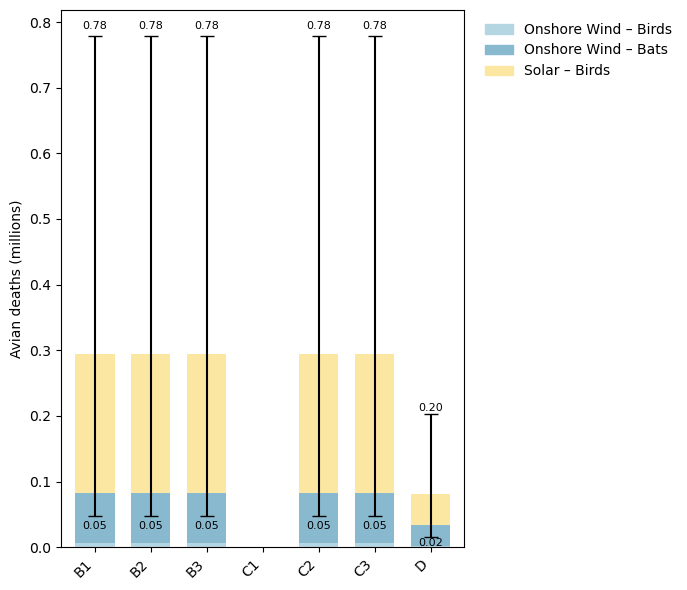

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ── 1) LOAD & STACK PATHWAY DATA ────────────────────────────────────────
file_path = "/Users/amirgazar/Documents/GitHub/Decarbonization-Tradeoffs/1 Decarbonization Pathways/Decarbonization_Pathways.xlsx"
all_sheets = pd.read_excel(file_path, sheet_name=None)
df_list = []
for sheet_name, df in all_sheets.items():
    df = df.copy()
    df["Pathway"] = sheet_name
    df_list.append(df)
decarb_pathways = pd.concat(df_list, ignore_index=True)

# ── 2) MANUAL CANADIAN HYDRO INJECTION FOR B3 ──────────────────────────
b3_hydro_map = {2025: 0, 2050: 3692.308}
decarb_pathways["Canadian Hydro"] = 0.0
mask_b3 = decarb_pathways["Pathway"] == "B3"
decarb_pathways.loc[mask_b3, "Canadian Hydro"] = (
    decarb_pathways.loc[mask_b3, "Year"]
                  .map(b3_hydro_map)
                  .fillna(0)
)

# ── 3) COMPUTE ΔCAPACITY 2025→2050 ─────────────────────────────────────
techs = ["Solar", "Onshore Wind"]
baseline = decarb_pathways["Year"].min()
df0 = decarb_pathways.query("Year == @baseline").set_index("Pathway")
df1 = decarb_pathways.query("Year == 2050").set_index("Pathway")
cap_diff = df1[techs] - df0[techs]
cap_diff = cap_diff.drop(index="A", errors="ignore")
pathways = cap_diff.index.tolist()

# ── 4) MONTE CARLO: BIRD & BAT MORTALITY ─────────────────────────────────
np.random.seed(42)
n_sims = 1000
samples = np.zeros((n_sims, len(pathways), 3))

for s in range(n_sims):
    bird_on = np.random.gamma(0.20, 2.54)
    bat_on  = np.random.gamma(1.538, 4.160)
    s_rate  = np.random.lognormal(np.log(1.214), 1.409)

    on_cap  = cap_diff["Onshore Wind"].values
    sol_cap = cap_diff["Solar"].values

    samples[s, :, 0] = bird_on * on_cap
    samples[s, :, 1] = bat_on  * on_cap
    samples[s, :, 2] = s_rate  * sol_cap

# convert to millions
samples /= 1e6

# ── 5) COMPUTE MEANS & 90% CI ON TOTALS ───────────────────────────────
mean_vals   = samples.mean(axis=0)       # (n_paths,3)
mean_df     = pd.DataFrame(
    mean_vals,
    index=pathways,
    columns=["Onshore Bird","Onshore Bat","Solar Bird"]
)

total_by_sim = samples.sum(axis=2)       # (n_sims, n_paths)
mean_total   = total_by_sim.mean(axis=0)
low_total    = np.percentile(total_by_sim,  5, axis=0)
high_total   = np.percentile(total_by_sim,  95, axis=0)

# asymmetric error bars
err_low   = mean_total - low_total
err_high  = high_total - mean_total
yerr      = np.vstack((err_low, err_high))

# ── 6) PLOT STACKED BAR + 90% CI ───────────────────────────────────────
colors     = {
    "Onshore Bird":"#B4D6E3",
    "Onshore Bat": "#89B9CF",
    "Solar Bird":  "#FBE7A1"
}
legend_map = {
    "Onshore Bird":"Onshore Wind – Birds",
    "Onshore Bat": "Onshore Wind – Bats",
    "Solar Bird":  "Solar – Birds"
}

fig, ax = plt.subplots(figsize=(7,6))
mean_df.plot(
    kind="bar", stacked=True,
    color=[colors[c] for c in mean_df.columns],
    width=0.7, ax=ax
)
ax.set_xticklabels(pathways, rotation=45, ha="right")
ax.set_ylabel("Avian deaths (millions)")

# error bars (skip C1)
mask = np.array(pathways) != "C1"
x    = np.arange(len(pathways))
x_err       = x[mask]
ymean_mask  = mean_total[mask]
yerr_masked = yerr[:, mask]

ax.errorbar(
    x_err, ymean_mask,
    yerr=yerr_masked,
    fmt="none", ecolor="black", capsize=5
)

# annotate the 10th & 90th percentile bounds
for idx in np.where(mask)[0]:
    xi = x[idx]
    lo = low_total[idx]
    hi = high_total[idx]
    span = hi - lo
    off  = span * 0.01
    ax.text(xi, hi + off, f"{hi:.2f}", ha="center", va="bottom", fontsize=8)
    ax.text(xi, lo - off, f"{lo:.2f}", ha="center", va="top",    fontsize=8)

handles = [
    plt.matplotlib.patches.Patch(color=colors[c], label=legend_map[c])
    for c in mean_df.columns
]
ax.legend(handles=handles, loc="upper left", bbox_to_anchor=(1.02,1), frameon=False)

plt.tight_layout()
plt.savefig("avian_deaths.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

# ── 7) TABULATE & SAVE EXCEL WITH 90% CI ───────────────────────────────
# species‐level 10th & 90th percentiles
ci_low_sp  = np.percentile(samples,  10, axis=0)  # (n_paths,3)
ci_high_sp = np.percentile(samples,  90, axis=0)

rows = ["Onshore Bird","Onshore Bat","Solar Bird","Sum"]
avian_table = pd.DataFrame(index=rows, columns=pathways, dtype=object)

# fill species rows
for j, cat in enumerate(rows[:-1]):
    for i, pw in enumerate(pathways):
        m  = mean_df.at[pw, cat]
        lo = ci_low_sp[i, j]
        hi = ci_high_sp[i, j]
        avian_table.at[cat, pw] = f"{m:.2f} ({lo:.2f}-{hi:.2f})"

# fill Sum row
for i, pw in enumerate(pathways):
    m  = mean_total[i]
    lo = low_total[i]
    hi = high_total[i]
    avian_table.at["Sum", pw] = f"{m:.2f} ({lo:.2f}-{hi:.2f})"

avian_table.index.name = "Category"
avian_table.insert(0, "Unit", ["Avian deaths (millions)"] * len(rows))

avian_table.to_excel(
    "avian_deaths_summary.xlsx",
    sheet_name="Avian deaths",
    startrow=1
)
